In [31]:
import casadi as csd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.stats import chi2, f

In [2]:
data = pd.read_csv('ABCD_data.csv')
data.head()

,t,ca,cb,cc,cd
0,0.204082,0.972924,1.574994,0.079085,-0.034651
1,0.408163,0.395468,1.452837,0.579926,0.024762
2,0.612245,0.140956,1.232427,0.436657,0.231741
3,0.816327,0.655300,1.022851,0.523273,0.128103
4,1.020408,0.529955,1.141678,0.747955,0.351513


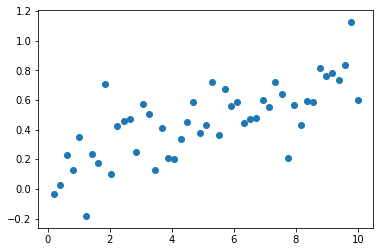

In [4]:
fig, ax = plt.subplots()
ax.scatter(data['t'], data['cd'])

In [5]:
s = np.array([[-1.0, -1.0, 1.0, 0.0],
              [0.0, -1.0, -1.0, 1.0]
             ])

In [6]:
def rxnfn(kf, tf, s):
    
    nr, nc = s.shape
    
    c = csd.MX.sym('c', nc)
    
    r = []
    for i in range(nr):
        ri = kf[i]
        for j in range(nc):
            if s[i, j] < 0:
                ri = ri * c[j] ** (-s[i, j])
        r.append(ri) 
        
    dc = []
    for i in range(nc):
        dci = 0
        for j in range(nr):
            dci = dci + s[j, i] * r[j]
        dc.append(dci)
        
    ode = {}
    ode['x'] = c
    ode['p'] = kf
    ode['ode'] = csd.vertcat(*dc)
    
    F = csd.integrator('F','cvodes',ode,{'tf':tf})
    
    return F

In [7]:
tgrid = np.append(0, data['t'].values)
meas_var = ['ca', 'cb', 'cc']
meas_var_idx = [0, 1, 2]

In [15]:
c0 = [1.0, 2.0, 0.0, 0.0]
kf = csd.MX.sym('kf', 2)
ssq = 0
for i in range(len(tgrid) - 1):
    F = rxnfn(kf = kf, tf = tgrid[i + 1] - tgrid[i], s = s)
    res = F(x0 = c0, p = kf)
    c0 = res['xf']
    for (j, var) in enumerate(meas_var):
        ssq = ssq + (data.iloc[i][var] - res['xf'][meas_var_idx[j]]) ** 2

In [16]:
ssqfn = csd.Function('ssqfn', [kf], [ssq])

In [26]:
# function to calcuate hessian of sum of squares with respect to p = (k1, k2)
ssqfn_hess_calc = csd.hessian(ssqfn(kf), kf)
ssqfn_hess = csd.Function('ssqfn_hess', [kf], [ssqfn_hess_calc[0]])

In [17]:
ssq

MX(@1=F([1, 2, 0, 0], kf, 0x1, 0x1, 0x1, 0x1){0}, @2=F(@1, kf, 0x1, 0x1, 0x1, 0x1){0}, @3=F(@2, kf, 0x1, 0x1, 0x1, 0x1){0}, @4=F(@3, kf, 0x1, 0x1, 0x1, 0x1){0}, @5=F(@4, kf, 0x1, 0x1, 0x1, 0x1){0}, @6=F(@5, kf, 0x1, 0x1, 0x1, 0x1){0}, @7=F(@6, kf, 0x1, 0x1, 0x1, 0x1){0}, @8=F(@7, kf, 0x1, 0x1, 0x1, 0x1){0}, @9=F(@8, kf, 0x1, 0x1, 0x1, 0x1){0}, @10=F(@9, kf, 0x1, 0x1, 0x1, 0x1){0}, @11=F(@10, kf, 0x1, 0x1, 0x1, 0x1){0}, @12=F(@11, kf, 0x1, 0x1, 0x1, 0x1){0}, @13=F(@12, kf, 0x1, 0x1, 0x1, 0x1){0}, @14=F(@13, kf, 0x1, 0x1, 0x1, 0x1){0}, @15=F(@14, kf, 0x1, 0x1, 0x1, 0x1){0}, @16=F(@15, kf, 0x1, 0x1, 0x1, 0x1){0}, @17=F(@16, kf, 0x1, 0x1, 0x1, 0x1){0}, @18=F(@17, kf, 0x1, 0x1, 0x1, 0x1){0}, @19=F(@18, kf, 0x1, 0x1, 0x1, 0x1){0}, @20=F(@19, kf, 0x1, 0x1, 0x1, 0x1){0}, @21=F(@20, kf, 0x1, 0x1, 0x1, 0x1){0}, @22=F(@21, kf, 0x1, 0x1, 0x1, 0x1){0}, @23=F(@22, kf, 0x1, 0x1, 0x1, 0x1){0}, @24=F(@23, kf, 0x1, 0x1, 0x1, 0x1){0}, @25=F(@24, kf, 0x1, 0x1, 0x1, 0x1){0}, @26=F(@25, kf, 0x1, 0x1, 0x1, 0

In [18]:
data.tail()

,t,ca,cb,cc,cd
44,9.183673,-0.227853,0.999986,0.173769,0.784113
45,9.387755,0.359683,0.331095,0.254534,0.733432
46,9.591837,-0.415916,0.217961,0.274379,0.834746
47,9.795918,0.249623,0.282635,0.450307,1.125097
48,10.000000,0.226174,0.454403,0.200841,0.602485


In [21]:
# NLP declaration
nlp = {'x': kf,'f': ssq};

# Solve using IPOPT
solver = csd.nlpsol('solver','ipopt',nlp)
res = solver(x0=[3, 3], lbx = 0, ubx = 10)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [29]:
p_est = res['x']
p_est

DM([0.949272, 0.212212])

In [32]:
## calculate covariance matrix

# number of estiamted parameters
n_est = 2
# number of data points
n_data = data.shape[0] * len(meas_var)


# hessian
H_sol = ssqfn_hess(p_est)
# mean sum of squares
msq = res['f'] / (n_data - n_est)
print("mean sum of squares", msq)

print("Covariance matrix")
cov = 2 * msq * linalg.inv(H_sol)
print(cov)

mean sum of squares 0.0428869
Covariance matrix

[[0.0162838, -0.000272307], 
 [-0.000272307, 0.000427446]]
